# Import

In [1]:
import os
import torch
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from bleu_eval import BLEU
import re
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt


def process_text(s):
    s = re.sub(r'\s\'\s', "'", s)
    s = re.sub(r'\s([\.\!\?\,])', r"\1", s)
    return s

In [2]:
print(os.listdir('./data'))

['.ipynb_checkpoints', 'eng-fra.txt', 'test_text.csv', 'train_text.csv']


# Build word dict

In [3]:
# with open('data/eng-fra.txt', 'r', encoding='utf-8') as f:
#     s = f.readline()

# text = pd.read_csv('data/eng-fra.txt', header=None, names=['eng', 'fra'], encoding='utf-8', sep='\t')[:12000]
# index = np.arange(text.shape[0])
# np.random.shuffle(index)
# text2 = text.loc[index[10000:12000]]
# text = text.loc[index[:10000]]
# text.to_csv('data/train_text.csv', index=False, encoding='utf-8', sep='\t')
# text2.to_csv('data/test_text.csv', index=False, encoding='utf-8', sep='\t')

In [4]:
text1 = pd.read_csv('data/train_text.csv', encoding='utf-8', sep='\t')
text2 = pd.read_csv('data/test_text.csv', encoding='utf-8', sep='\t')

In [5]:
print(text1.shape, text2.shape)

(10000, 2) (2000, 2)


In [6]:
text = pd.concat([text1, text2], axis=0)
print(text.shape)

(12000, 2)


In [7]:
cv1 = CountVectorizer(min_df=3,token_pattern=r"\b\w+\b|!|\?|\'|\.")
cv2 = CountVectorizer(min_df=5,token_pattern=r"\b\w+\b|!|\?|\'|\.")
cv1.fit(text.eng)
cv2.fit(text.fra)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern="\\b\\w+\\b|!|\\?|\\'|\\.",
                tokenizer=None, vocabulary=None)

In [8]:
def build_word_dict(cv):
    num_word = len(cv.get_feature_names())
    word_index = {k:v+1 for k,v in cv.vocabulary_.items()}  # 1~num_word vaild index
    word_index['<bos>'] = num_word+1
    word_index['<eos>'] = num_word+2
    index_word = dict(zip(word_index.values(), word_index.keys()))
    return num_word+3, word_index, index_word

In [9]:
num_word_eng, word_index_eng, index_word_eng = build_word_dict(cv1)
num_word_fra, word_index_fra, index_word_fra = build_word_dict(cv2)
print(num_word_eng, num_word_fra)

1205 914


In [10]:
len(word_index_eng)

1204

In [11]:
def text2int(word_index, texts, add_xos=False):
    tokenizer = CountVectorizer(token_pattern=r"\b\w+\b|!|\?|\'|\.").build_tokenizer()
#     return [[word_index.get(j, 0)+1 for j in tokenizer(i.lower())] for i in texts]
    res = []
    bos, eos = [word_index.get('<bos>')], [word_index.get('<eos>')]
    for t in texts:
        if add_xos:
            res.append(bos + [word_index.get(i, 0) for i in tokenizer(t.lower())] + eos)
        else:
            res.append([word_index.get(i, 0) for i in tokenizer(t.lower())])
    return res

def int2text(index_word, intcode):
    return [' '.join([index_word.get(j, '<null>') for j in i] ) for i in intcode]

def word_count(cv, texts):
    trans = cv.transform(texts)
    wc = trans.sum(axis=0)
    wc = np.asarray(wc).squeeze()
    return {k:v for k, v in zip(cv.get_feature_names(), wc)}

def padding(s, pad=0):
    max_len = max(map(len, s))
    res = []
    for ss in s:
        t = [0]*max_len
        t[max_len-len(ss):]=ss
        res.append(t)
    return res

# Model

## EncoderRNN & DecoderRNN

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size)

    def forward(self, input, hidden):
        x = self.embedding(input)  # input: (seq_len, batch_size)
        out, h_n = self.gru(x, hidden)  # input: (seq_len, batch_size, embedding_dim)
        return out, h_n

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        x = self.embedding(input)  # input: (seq_len=1, batch_size)
#         x = F.relu(x)  # input: (seq_len=1, batch_size, embedding_dim)
        output, h_1 = self.gru(x, hidden)
#         out = F.softmax(self.out(output[0]), dim=1)  # out: (batch_size, hidden_size)
        out = self.softmax(self.out(output[0]))  # output[0]: (batch_size, hidden_size)
        return out, h_1  # hidden: (1, batch_size, hidden_size)

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

## AttnDecoderRNN

Attention 实现方式 1：decoder hidden vector 与 输入做 attention 产生权重

<img src="mt-atten.png" width="350px">

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):  # input: (1, b), hidden: (1, b, h), encoder_outputs: (s, b, h)
        embedded = self.embedding(input)  # embedded: (1, b, h)
#         embedded = self.dropout(embedded)
#         print(embedded.shape)
#         print(embedded[0].shape, hidden[0].shape)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)  # attn_weights: (b, l)
#         print(attn_weights.shape)
        
        encoder_outputs_len = encoder_outputs.shape[0]
        e_out = torch.zeros(self.max_length, encoder_outputs.shape[1], encoder_outputs.shape[2], device=device)
        for i in range(min(encoder_outputs_len, self.max_length)):
#             e_out[-i-1] = encoder_outputs[-i-1]
            e_out[i] = encoder_outputs[i]
        temp1 = e_out.permute(1, 2, 0)  # (b, h, l)
        temp2 = attn_weights.unsqueeze(2)  # (b, l, 1)
#         print(temp1.shape, temp2.shape)
        
        attn_applied = torch.bmm(temp1, temp2).permute(2, 0, 1)  # (1, b, h)
#         print(attn_applied.shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)  # (b, 2*h)
        output = self.attn_combine(output).unsqueeze(0)  # (1, b, h)

#         output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)  # (b, d)
#         print(output.shape)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## AttnDecoderRNN_2

Attention 实现方式 2：decoder hidden vector 与 encoder outputs 做 attention 产生权重

<img src="mt-atten2.jpg" width="550px">

In [14]:
class AttnDecoderRNN_2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size, padding_idx=0)
#         self.attn1 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.attn2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):  # input: (1, b), hidden: (1, b, h), encoder_outputs: (s, b, h)
        emb = self.embedding(input)  # shape: (1, b, h)
        
        encoder_outputs_len = encoder_outputs.shape[0]
        e_out = torch.zeros(self.max_length, encoder_outputs.shape[1], encoder_outputs.shape[2], device=device)
        for i in range(min(encoder_outputs_len, self.max_length)):
#             e_out[-i-1] = encoder_outputs[-i-1]
            e_out[i] = encoder_outputs[i]
        temp1 = e_out.permute(1,0,2)  # (b, l, h)
        temp2 = hidden.permute(1,2,0)  # (b, h, 1)
#         print(temp1.device, temp2.device)
        attn_weights = F.softmax(torch.bmm(temp1, temp2).squeeze(2), dim=1)  # (b, l)
        attn_applied = torch.bmm(e_out.permute(1, 2, 0), attn_weights.unsqueeze(2)).permute(2, 0, 1)  # (1, b, h)
        
        x = torch.cat((emb, attn_applied), dim=2)  # (1, b, 2*h)
        x = self.attn_combine(x)  # (1, b, h)
        out, hidden, = self.gru(x, hidden)
        output = F.log_softmax(self.out(out[0]), dim=1)  # (b, d)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
# b = 3
# h = 8
# s = 11
# l = 10
# d = 20

In [16]:
# ade = AttnDecoderRNN_2(h, d)

In [17]:
# x0 = torch.ones(1, b, dtype=torch.long)
# h0 = torch.zeros(1, b, h)
# e_out = torch.ones(s, b, h)

In [18]:
# d_out = ade(x0, h0, e_out)

In [19]:
# d_out[2]

## Self-attention

In [119]:
class SelfAttenEncoder(nn.Module):
    
    def __init__(self, input_size, latent_dim):
        super().__init__()
#         self.input_len = input_len
#         self.latent_dim = latent_dim
        self.Embedding = nn.Embedding(input_size, latent_dim, padding_idx=0)
#         self.T = nn.Linear(latent_dim, latent_dim)
        self.Wq = nn.Linear(latent_dim, latent_dim)
        self.Wk = nn.Linear(latent_dim, latent_dim)
        self.Wv = nn.Linear(latent_dim, latent_dim)
        
    def forward(self, input):
        x = self.Embedding(input)  # (s, b) -> (s, b, h)
#         x = F.relu(self.T(x))
        q = self.Wq(x)  # (s, b, h) -> (s, b, h)
        k = self.Wq(x)  # (s, b, h) -> (s, b, h)
        v = self.Wq(x)  # (s, b, h) -> (s, b, h)
        a = F.softmax(torch.bmm(q.permute(1,0,2), k.permute(1,2,0)), dim=1)  # (b, s, s)
        out = torch.bmm(a, v.permute(1,0,2)).permute(1,0,2)  # (s, b, h)
        out_mean = out.mean(dim=0)  # (b, h)
        return out, out_mean, a

    
class SelfAttenDecoder(nn.Module):
    
    def __init__(self, output_size, latent_dim, max_len=9):
        super().__init__()
        self.max_len = max_len
        self.Wq = nn.Linear(latent_dim, latent_dim)
        self.Wk = nn.Linear(latent_dim, latent_dim)
        self.Wv = nn.Linear(latent_dim, latent_dim)
        self.out = nn.Linear(latent_dim, output_size)
        
    def forward(self, input):
        x = torch.zeros(self.max_len, input.shape[1], input.shape[2], device=device)
        for i in range(min(self.max_len, input.shape[0])):
            x[i] = input[i]
        q = self.Wq(x)  # (s, b, h) -> (s, b, h)
        k = self.Wq(x)  # (s, b, h) -> (s, b, h)
        v = self.Wq(x)  # (s, b, h) -> (s, b, h)
        a = F.softmax(torch.bmm(q.permute(1,0,2), k.permute(1,2,0)), dim=1)  # (b, s, s)
        out = torch.bmm(a, v.permute(1,0,2)).permute(1,0,2)  # (s, b, h)
        out = F.log_softmax(self.out(out), dim=2)  # (s, b, d)
        return out, a

In [21]:
b = 3
h = 8
s = 6
l = 10
d = 20

In [22]:
# selfatten = SelfAttenEncoder(d, h)
# sad = SelfAttenDecoder(d, h)

In [23]:
# x = torch.randint(d, (s, b), dtype=torch.long)
x = torch.rand(s, b, h)
x.shape

torch.Size([6, 3, 8])

In [24]:
# y = sad(x)

In [27]:
# y.shape
# y[1][0]

In [135]:
lstm = nn.LSTM(d,h,bidirectional=True)

In [140]:
x = torch.rand(s, b, d)
h0 = torch.zeros(2, b, h)
c0 = torch.zeros(2, b, h)

In [141]:
y = lstm(x, (h0,c0))

In [152]:
y[1][1].shape

torch.Size([2, 3, 8])

# Dataset

In [28]:
class Datagen:
    
    def __init__(self, text_table, batch_size=5, shuffle=True):
        super().__init__()
        self.text_table = text_table
        self.batch_size = batch_size
        self.num_samples = text_table.shape[0]
        self.shuffle = shuffle
        self._index = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(self._index)
        mod = self.num_samples % batch_size
        if mod > 0:
            self._index = np.hstack([self._index, np.random.choice(self._index, self.batch_size-mod)])
        self._idx_bat = [self._index[i:i+self.batch_size] for i in range(0, self.num_samples, self.batch_size)] 
        
    def __len__(self):
        return int(np.ceil(self.num_samples/self.batch_size))
    
    def shuffle_data(self):
        np.random.shuffle(self._index)
        self._idx_bat = [self._index[i:i+self.batch_size] for i in range(0, self.num_samples, self.batch_size)] 
    
    def __getitem__(self, i):
        idx = self._idx_bat[i]
        input_text = self.text_table.iloc[idx, 1].tolist()
        target_text = self.text_table.iloc[idx, 0].tolist()
        x = text2int(word_index_fra, input_text)
        x = padding(x)
        y = text2int(word_index_eng, target_text, add_xos=True)
        y = padding(y)
        x = torch.tensor(x, dtype=torch.long).permute(1,0)
        y = torch.tensor(y, dtype=torch.long).permute(1,0)
        return x, y[:-1,:], y[1:,:]

# Training

## Train RNN encoder-decoder

In [90]:
batch_size = 2
latent_dim = 256
learning_rate = .002
epochs = 20
start_epoch = 1

teacher_forcing_rate = 1
write_log = False
change_lr = False


def predict(encoder, decoder, input_text, max_len=10):
    with torch.no_grad():
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        _, context_vector = encoder(input_tensor, encoder.initHidden(1))
    #     print(context_vector)
        bos_tensor = torch.tensor(word_index_eng['<bos>'], dtype=torch.long).view(1,1).to(device)
        decoder_out, decoder_state = decoder(bos_tensor, context_vector)
    #     print(decoder_out.sum())
        pred_int = decoder_out.argmax().item()
        input_tensor = decoder_out.argmax().view(1,1)
    #     print(input_tensor)
    #     print(pred_int)
        res = []
        count = 0
        while pred_int!=word_index_eng['<eos>'] and count<max_len:
            res.append(pred_int)
            decoder_out, decoder_state = decoder(input_tensor, decoder_state)
            pred_int = decoder_out.argmax().item()
            input_tensor = decoder_out.argmax().view(1,1)
            count += 1
    return int2text(index_word_eng, [res])[0]


def evel_bleu(test_pair, encoder, decoder):
    res = []
    for i in range(test_pair.shape[0]):
        pred = predict(encoder, decoder, test_pair.iloc[i, 1])
        pred = process_text(pred)
        res.append(BLEU(pred, test_pair.iloc[i, 0]))
    return np.mean(res)


def calc_acc(true, pred):
    with torch.no_grad():
        acc = torch.eq(true, pred).float().mean().item()
    return acc
    

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 2:
        lr = .002
    elif epoch < 7:
        lr = .001
    elif epoch < 12:
        lr = .0005
    elif epoch < 16:
        lr = .0002  # .0002
    else:
        lr = .0001  # .0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [105]:
dataset = Datagen(text1, batch_size=batch_size, shuffle=False)
num_iter_one_epoch = len(dataset)
print(num_iter_one_epoch)

5000


In [101]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderRNN(num_word_fra, latent_dim).to(device)
decoder = DecoderRNN(latent_dim, num_word_eng).to(device)

In [102]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
loss_fun = nn.NLLLoss()
# loss_fun = nn.CrossEntropyLoss()

In [106]:
if write_log:
    writer = SummaryWriter(log_dir='logdir')

encoder_init_state = encoder.initHidden(batch_size)
# decoder_init_state = decoder.initHidden(batch_size)
for i in range(start_epoch, epochs+start_epoch):
    print('Epoch {}/{}'.format(i, epochs+start_epoch-1))
    dataset.shuffle_data()
    
    if change_lr:
        adjust_learning_rate(encoder_optimizer, i)
        adjust_learning_rate(decoder_optimizer, i)
    
    epoch_acc = []
    epoch_loss = []
    for j in range(0, num_iter_one_epoch):
        x, y1, y2 = dataset[j]  # x, y1, y2 shape: (seq_len, batch_size)
        x = x.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        _, context_vector = encoder(x, encoder_init_state)
        decoder_state = context_vector
        decoder_out = []
        decoder_input = y1[0].view(1,-1)
        for k in range(y1.shape[0]):    
            out, decoder_state = decoder(decoder_input, decoder_state)  # out shape: (batch_size, class)
            try:
                decoder_input = y1[k + 1].view(1, -1) if np.random.rand() < teacher_forcing_rate \
                        else out.argmax(dim=1).view(1, -1).detach()
            except:
                pass
            decoder_out.append(out)
        decoder_outputs = torch.stack(decoder_out)
        decoder_outputs_int = torch.argmax(decoder_outputs, dim=2)
        acc = calc_acc(y2.view(-1), decoder_outputs_int.view(-1))
        loss = loss_fun(decoder_outputs.view(-1, num_word_eng), y2.view(-1))
        print('{}/{}  loss: {:.3f} - acc: {:.3f}'.format(j+1, num_iter_one_epoch, loss.item(), acc), end='\r')
        
        epoch_acc.append(acc)
        epoch_loss.append(loss.item())
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        if write_log:
            writer.add_scalar('loss', loss, (i-1)*num_iter_one_epoch+j+1)
            writer.add_scalar('acc', acc, (i-1)*num_iter_one_epoch+j+1)
        
    test_bleu = evel_bleu(text2, encoder, decoder)
    train_bleu = evel_bleu(text1[:2000], encoder, decoder)
    print('\nloss: {:.3f} - acc: {:.3f} - train_bleu: {:.3f} - test_bleu: {:.3f}'\
          .format(np.mean(epoch_loss), np.mean(epoch_acc), train_bleu, test_bleu))
    
    if write_log:
        writer.add_scalar('test_bleu', test_bleu, i*num_iter_one_epoch)
        writer.add_scalar('train_bleu', train_bleu, i*num_iter_one_epoch)

Epoch 1/20
5000/5000  loss: 1.339 - acc: 0.833
train_bleu: 0.4249830833937208 - test_bleu: 0.357
Epoch 2/20
5000/5000  loss: 1.533 - acc: 0.750
train_bleu: 0.5091463773178746 - test_bleu: 0.403
Epoch 3/20
5000/5000  loss: 0.270 - acc: 1.000
train_bleu: 0.6770244914829243 - test_bleu: 0.494
Epoch 4/20
5000/5000  loss: 0.372 - acc: 0.900
train_bleu: 0.7097078597756856 - test_bleu: 0.508
Epoch 5/20
5000/5000  loss: 0.858 - acc: 0.833
train_bleu: 0.7303130907978316 - test_bleu: 0.510
Epoch 6/20
5000/5000  loss: 0.471 - acc: 0.900
train_bleu: 0.7431641681128058 - test_bleu: 0.518
Epoch 7/20
5000/5000  loss: 0.644 - acc: 0.833
train_bleu: 0.751857379497905 - test_bleu: 0.521
Epoch 8/20
5000/5000  loss: 0.448 - acc: 0.800
train_bleu: 0.7771868047490272 - test_bleu: 0.533
Epoch 9/20
5000/5000  loss: 0.217 - acc: 0.857
train_bleu: 0.7861927242723102 - test_bleu: 0.537
Epoch 10/20
5000/5000  loss: 0.077 - acc: 1.000
train_bleu: 0.7910976885541476 - test_bleu: 0.533
Epoch 11/20
5000/5000  loss: 0

In [107]:
writer.close()

In [30]:
torch.save(encoder.state_dict(), './model/encoder.mdl')
torch.save(decoder.state_dict(), './model/decoder.mdl')

In [86]:
encoder.state_dict().keys()

odict_keys(['embedding.weight', 'gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0'])

In [43]:
print(decoder)

DecoderRNN(
  (embedding): Embedding(1205, 256, padding_idx=0)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=1205, bias=True)
  (softmax): LogSoftmax()
)


## Training with attention

In [73]:
batch_size = 5
latent_dim = 256
learning_rate = .001
epochs = 1
start_epoch = 1

teacher_forcing_rate = 1
write_log = False
change_lr = False


def predict(encoder, decoder, input_text, max_len=10):
    with torch.no_grad():
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        e_out, context_vector = encoder(input_tensor, encoder.initHidden(1))
    #     print(context_vector)
        bos_tensor = torch.tensor(word_index_eng['<bos>'], dtype=torch.long).view(1,1).to(device)
        decoder_out, decoder_state, attn_weights = decoder(bos_tensor, context_vector, e_out)
    #     print(decoder_out.sum())
        pred_int = decoder_out.argmax().item()
        input_tensor = decoder_out.argmax().view(1,1)
    #     print(input_tensor)
    #     print(pred_int)
        res = []
        count = 0
        while pred_int!=word_index_eng['<eos>'] and count<max_len:
            res.append(pred_int)
            decoder_out, decoder_state, attn_weights = decoder(input_tensor, decoder_state, e_out)
            pred_int = decoder_out.argmax().item()
            input_tensor = decoder_out.argmax().view(1,1)
            count += 1
    return int2text(index_word_eng, [res])[0]

def predict_with_atten(encoder, decoder, input_text, max_len=10):
    with torch.no_grad():
        atten_w = []
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        e_out, context_vector = encoder(input_tensor, encoder.initHidden(1))
    #     print(context_vector)
        bos_tensor = torch.tensor(word_index_eng['<bos>'], dtype=torch.long).view(1,1).to(device)
        decoder_out, decoder_state, attn_weights = decoder(bos_tensor, context_vector, e_out)

        atten_w.append(attn_weights)
    #     print(decoder_out.sum())
        pred_int = decoder_out.argmax().item()
        input_tensor = decoder_out.argmax().view(1,1)
    #     print(input_tensor)
    #     print(pred_int)
        res = []
        count = 0
        while pred_int!=word_index_eng['<eos>'] and count<max_len:
            res.append(pred_int)
            decoder_out, decoder_state, attn_weights = decoder(input_tensor, decoder_state, e_out)

            atten_w.append(attn_weights)
            pred_int = decoder_out.argmax().item()
            input_tensor = decoder_out.argmax().view(1,1)
            count += 1
        atten_w = torch.cat(atten_w, dim=0).cpu().numpy()
    return int2text(index_word_eng, [res])[0], atten_w


def evel_bleu(test_pair, encoder, decoder):
    res = []
    for i in range(test_pair.shape[0]):
        pred = predict(encoder, decoder, test_pair.iloc[i, 1])
        pred = process_text(pred)
        res.append(BLEU(pred, test_pair.iloc[i, 0]))
    return np.mean(res)


def calc_acc(true, pred):
    with torch.no_grad():
        acc = torch.eq(true, pred).float().mean().item()
    return acc

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 2:
        lr = .005
    elif epoch < 6:
        lr = .002
    elif epoch < 9:
        lr = .001
    elif epoch < 12:
        lr = .0005
    else:
        lr = .0002
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [27]:
dataset = Datagen(text1, batch_size=batch_size, shuffle=False)
num_iter_one_epoch = len(dataset)
print(num_iter_one_epoch)

2000


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
torch.cuda.empty_cache()
encoder = EncoderRNN(num_word_fra, latent_dim).to(device)
decoder = AttnDecoderRNN(latent_dim, num_word_eng, max_length=7).to(device)

In [26]:
encoder.load_state_dict(torch.load('./model/encoder.mdl'))
decoder.load_state_dict(torch.load('./model/decoder.mdl'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
loss_fun = nn.NLLLoss()
# loss_fun = nn.CrossEntropyLoss()

In [141]:
if write_log:
    writer = SummaryWriter(log_dir='logdir')

In [76]:
encoder_init_state = encoder.initHidden(batch_size)
# decoder_init_state = decoder.initHidden(batch_size)
for i in range(start_epoch, epochs+start_epoch):
    print('Epoch {}/{}'.format(i, epochs+start_epoch-1))
    dataset.shuffle_data()
    if change_lr:
        adjust_learning_rate(encoder_optimizer, i)
        adjust_learning_rate(decoder_optimizer, i)
        
    epoch_acc = []
    epoch_loss = []
    
    for j in range(0, num_iter_one_epoch):
        x, y1, y2 = dataset[j]  # x, y1, y2 shape: (seq_len, batch_size)
        x = x.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        e_out, context_vector = encoder(x, encoder_init_state)
        decoder_state = context_vector
        decoder_out = []
        decoder_input = y1[0].view(1,-1)
        for k in range(y1.shape[0]):    
            out, decoder_state, attn_weights = decoder(decoder_input, decoder_state, e_out)  # out shape: (batch_size, class)
            try:
                decoder_input = y1[k + 1].view(1, -1) if np.random.rand() < teacher_forcing_rate \
                        else out.argmax(dim=1).view(1, -1).detach()
            except:
                pass
            decoder_out.append(out)
        decoder_outputs = torch.stack(decoder_out)
        decoder_outputs_int = torch.argmax(decoder_outputs, dim=2)
        acc = calc_acc(y2.view(-1), decoder_outputs_int.view(-1))
        loss = loss_fun(decoder_outputs.view(-1, num_word_eng), y2.view(-1))
        print('{}/{}  loss: {:.3f} - acc: {:.3f}'.format(j+1, num_iter_one_epoch, loss.item(), acc), end='\r')
        
        epoch_acc.append(acc)
        epoch_loss.append(loss.item())
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        if write_log:
            writer.add_scalar('loss', loss, (i-1)*num_iter_one_epoch+j+1)
            writer.add_scalar('acc', acc, (i-1)*num_iter_one_epoch+j+1)
        
    test_bleu = evel_bleu(text2, encoder, decoder)
    train_bleu = evel_bleu(text1[:2000], encoder, decoder)
    print('\nloss: {:.3f} - acc: {:.3f} - train_bleu: {:.3f} - test_bleu: {:.3f}'\
          .format(np.mean(epoch_loss), np.mean(epoch_acc), train_bleu, test_bleu))
    
    if write_log:
        writer.add_scalar('test_bleu', test_bleu, i*num_iter_one_epoch)
        writer.add_scalar('train_bleu', train_bleu, i*num_iter_one_epoch)

Epoch 1/1
2000/2000  loss: 0.157 - acc: 0.971
loss: 0.371 - acc: 0.879 - train_bleu: 0.706 - test_bleu: 0.480


In [160]:
writer.close()

In [70]:
torch.save(encoder.state_dict(), './model/encoder.mdl')
torch.save(decoder.state_dict(), './model/decoder.mdl')

## Train self-attention as encoder

In [153]:
latent_dim = 256
batch_size = 2
learning_rate = .001
epochs = 10
start_epoch = 1

teacher_forcing_rate = 1
write_log = False
change_lr = False


def predict(encoder, decoder, input_text, max_len=10):
    with torch.no_grad():
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        _, context_vector, _ = encoder(input_tensor)
    #     print(context_vector)
        bos_tensor = torch.tensor(word_index_eng['<bos>'], dtype=torch.long).view(1,1).to(device)
        decoder_out, decoder_state = decoder(bos_tensor, context_vector.unsqueeze(0))
    #     print(decoder_out.sum())
        pred_int = decoder_out.argmax().item()
        input_tensor = decoder_out.argmax().view(1,1)
    #     print(input_tensor)
    #     print(pred_int)
        res = []
        count = 0
        while pred_int!=word_index_eng['<eos>'] and count<max_len:
            res.append(pred_int)
            decoder_out, decoder_state = decoder(input_tensor, decoder_state)
            pred_int = decoder_out.argmax().item()
            input_tensor = decoder_out.argmax().view(1,1)
            count += 1
    return int2text(index_word_eng, [res])[0]


def predict_with_self_atten(encoder, decoder, input_text, max_len=10):
    with torch.no_grad():
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        _, context_vector, sat_w = encoder(input_tensor)
    #     print(context_vector)
        bos_tensor = torch.tensor(word_index_eng['<bos>'], dtype=torch.long).view(1,1).to(device)
        decoder_out, decoder_state = decoder(bos_tensor, context_vector.unsqueeze(0))
    #     print(decoder_out.sum())
        pred_int = decoder_out.argmax().item()
        input_tensor = decoder_out.argmax().view(1,1)
    #     print(input_tensor)
    #     print(pred_int)
        res = []
        count = 0
        while pred_int!=word_index_eng['<eos>'] and count<max_len:
            res.append(pred_int)
            decoder_out, decoder_state = decoder(input_tensor, decoder_state)
            pred_int = decoder_out.argmax().item()
            input_tensor = decoder_out.argmax().view(1,1)
            count += 1
    return int2text(index_word_eng, [res])[0], sat_w.squeeze(0).cpu().numpy()


def evel_bleu(test_pair, encoder, decoder):
    res = []
    for i in range(test_pair.shape[0]):
        pred = predict(encoder, decoder, test_pair.iloc[i, 1])
        pred = process_text(pred)
        res.append(BLEU(pred, test_pair.iloc[i, 0]))
    return np.mean(res)


def calc_acc(true, pred):
    with torch.no_grad():
        acc = torch.eq(true, pred).float().mean().item()
    return acc
    

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 2:
        lr = .002
    elif epoch < 7:
        lr = .001
    elif epoch < 12:
        lr = .0005
    elif epoch < 16:
        lr = .0002  # .0002
    else:
        lr = .0001  # .0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [148]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
sat_encoder = SelfAttenEncoder(num_word_fra, latent_dim=latent_dim).to(device)
decoder = DecoderRNN(latent_dim, num_word_eng).to(device)

In [154]:
dataset = Datagen(text1, batch_size=batch_size, shuffle=False)
num_iter_one_epoch = len(dataset)
print(num_iter_one_epoch)

5000


In [150]:
sat_encoder_optimizer = optim.Adam(sat_encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
loss_fun = nn.NLLLoss()

In [155]:
if write_log:
    writer = SummaryWriter(log_dir='logdir')
    

for i in range(start_epoch, epochs+start_epoch):
    print('Epoch {}/{}'.format(i, epochs+start_epoch-1))
    dataset.shuffle_data()
    
    if change_lr:
        adjust_learning_rate(sat_encoder_optimizer, i)
        adjust_learning_rate(decoder_optimizer, i)
    
    epoch_acc = []
    epoch_loss = []
    for j in range(0, num_iter_one_epoch):
        x, y1, y2 = dataset[j]  # x, y1, y2 shape: (seq_len, batch_size)
        x = x.to(device)
        y1 = y1.to(device)
        y2 = y2.to(device)
        sat_encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        _, context_vector, _ = sat_encoder(x)
        decoder_state = context_vector.unsqueeze(0)
        decoder_out = []
        decoder_input = y1[0].view(1,-1)
        for k in range(y1.shape[0]):    
            out, decoder_state = decoder(decoder_input, decoder_state)  # out shape: (batch_size, class)
            try:
                decoder_input = y1[k + 1].view(1, -1) if np.random.rand() < teacher_forcing_rate \
                        else out.argmax(dim=1).view(1, -1).detach()
            except:
                pass
            decoder_out.append(out)
        decoder_outputs = torch.stack(decoder_out)
        decoder_outputs_int = torch.argmax(decoder_outputs, dim=2)
        acc = calc_acc(y2.view(-1), decoder_outputs_int.view(-1))
        loss = loss_fun(decoder_outputs.view(-1, num_word_eng), y2.view(-1))
        print('{}/{}  loss: {:.3f} - acc: {:.3f}'.format(j+1, num_iter_one_epoch, loss.item(), acc), end='\r')
        
        epoch_acc.append(acc)
        epoch_loss.append(loss.item())
        
        loss.backward()
        sat_encoder_optimizer.step()
        decoder_optimizer.step()
        
        if write_log:
            writer.add_scalar('loss', loss, (i-1)*num_iter_one_epoch+j+1)
            writer.add_scalar('acc', acc, (i-1)*num_iter_one_epoch+j+1)
        
    test_bleu = evel_bleu(text2, sat_encoder, decoder)
    train_bleu = evel_bleu(text1[:2000], sat_encoder, decoder)
    print('\nloss: {:.3f} - acc: {:.3f} - train_bleu: {:.3f} - test_bleu: {:.3f}'\
          .format(np.mean(epoch_loss), np.mean(epoch_acc), train_bleu, test_bleu))
    
    if write_log:
        writer.add_scalar('test_bleu', test_bleu, i*num_iter_one_epoch)
        writer.add_scalar('train_bleu', train_bleu, i*num_iter_one_epoch)

Epoch 1/10
5000/5000  loss: 0.386 - acc: 0.9009
loss: 0.601 - acc: 0.846 - train_bleu: 0.646 - test_bleu: 0.464
Epoch 2/10
5000/5000  loss: 0.452 - acc: 0.786
loss: 0.545 - acc: 0.854 - train_bleu: 0.640 - test_bleu: 0.462
Epoch 3/10
5000/5000  loss: 0.321 - acc: 0.900
loss: 0.542 - acc: 0.856 - train_bleu: 0.667 - test_bleu: 0.491
Epoch 4/10
5000/5000  loss: 0.838 - acc: 0.8330
loss: 0.535 - acc: 0.859 - train_bleu: 0.659 - test_bleu: 0.478
Epoch 5/10
5000/5000  loss: 0.063 - acc: 1.0009
loss: 0.541 - acc: 0.860 - train_bleu: 0.661 - test_bleu: 0.479
Epoch 6/10
5000/5000  loss: 0.541 - acc: 0.900
loss: 0.526 - acc: 0.860 - train_bleu: 0.650 - test_bleu: 0.471
Epoch 7/10
5000/5000  loss: 0.079 - acc: 0.929
loss: 0.524 - acc: 0.864 - train_bleu: 0.669 - test_bleu: 0.489
Epoch 8/10
5000/5000  loss: 0.983 - acc: 0.786
loss: 0.530 - acc: 0.863 - train_bleu: 0.664 - test_bleu: 0.484
Epoch 9/10
5000/5000  loss: 0.162 - acc: 0.917
loss: 0.530 - acc: 0.862 - train_bleu: 0.675 - test_bleu: 0.47

In [137]:
torch.save(sat_encoder.state_dict(), './model/sat_encoder.mdl')
torch.save(decoder.state_dict(), './model/decoder.mdl')

## Train self-attention as encoder and decoder

- 好像不 work

In [157]:
latent_dim = 256
batch_size = 5
learning_rate = .002
epochs = 2
start_epoch = 1
max_len = 9

# teacher_forcing_rate = 1
write_log = False
change_lr = False


def predict(encoder, decoder, input_text):
    with torch.no_grad():
        input_code = text2int(word_index_fra, [input_text])
        input_tensor = torch.tensor(input_code, dtype=torch.long).permute(1,0).to(device)
        encoder_outputs,_ , _ = encoder(input_tensor)
        decoder_ouputs, _ = decoder(encoder_outputs)
        pred_int = decoder_outputs.argmax(dim=2).permute(1,0).cpu().numpy().tolist()
        pred_text = int2text(index_word_eng, pred_int)[0]
    return pred_text


def evel_bleu(test_pair, encoder, decoder):
    res = []
    for i in range(test_pair.shape[0]):
        pred = predict(encoder, decoder, test_pair.iloc[i, 1])
        pred = process_text(pred)
        res.append(BLEU(pred, test_pair.iloc[i, 0]))
    return np.mean(res)


def calc_acc(true, pred):
    with torch.no_grad():
        acc = torch.eq(true, pred).float().mean().item()
    return acc
    

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    if epoch < 2:
        lr = .002
    elif epoch < 7:
        lr = .001
    elif epoch < 12:
        lr = .0005
    elif epoch < 16:
        lr = .0002  # .0002
    else:
        lr = .0001  # .0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [154]:
dataset = Datagen(text1, batch_size=batch_size, shuffle=False)
num_iter_one_epoch = len(dataset)
print(num_iter_one_epoch)

2000


In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
sat_encoder = SelfAttenEncoder(num_word_fra, latent_dim=latent_dim).to(device)
sat_decoder = SelfAttenDecoder(num_word_eng, latent_dim, max_len=9).to(device)

In [155]:
sat_encoder_optimizer = optim.Adam(sat_encoder.parameters(), lr=learning_rate)
sat_decoder_optimizer = optim.Adam(sat_decoder.parameters(), lr=learning_rate)
loss_fun = nn.NLLLoss()

In [158]:
if write_log:
    writer = SummaryWriter(log_dir='logdir')
    

for i in range(start_epoch, epochs+start_epoch):
    print('Epoch {}/{}'.format(i, epochs+start_epoch-1))
    dataset.shuffle_data()
    
    if change_lr:
        adjust_learning_rate(sat_encoder_optimizer, i)
        adjust_learning_rate(sat_decoder_optimizer, i)
    
    epoch_acc = []
    epoch_loss = []
    for j in range(0, num_iter_one_epoch):
        x, _, y2 = dataset[j]  # x, y1, y2 shape: (seq_len, batch_size)
        x = x.to(device)
#         y1 = y1.to(device)
        valid_len = y2.shape[0]
        y = torch.zeros(max_len, batch_size, dtype=torch.long)
        for i in range(min(max_len, valid_len)): y[i] = y2[i]
        y = y.to(device)
        sat_encoder_optimizer.zero_grad()
        sat_decoder_optimizer.zero_grad()
        encoder_outputs, _, _ = sat_encoder(x)
#         decoder_state = context_vector.unsqueeze(0)
#         decoder_out = []
#         decoder_input = y1[0].view(1,-1)
#         for k in range(y1.shape[0]):    
#             out, decoder_state = decoder(decoder_input, decoder_state)  # out shape: (batch_size, class)
#             try:
#                 decoder_input = y1[k + 1].view(1, -1) if np.random.rand() < teacher_forcing_rate \
#                         else out.argmax(dim=1).view(1, -1).detach()
#             except:
#                 pass
#             decoder_out.append(out)
#         decoder_outputs = torch.stack(decoder_out)
        decoder_outputs, _ = sat_decoder(encoder_outputs)
        decoder_outputs_int = torch.argmax(decoder_outputs, dim=2)
        acc = calc_acc(y.view(-1), decoder_outputs_int.view(-1))
        loss = loss_fun(decoder_outputs.view(-1, num_word_eng), y.view(-1))
        print('{}/{}  loss: {:.3f} - acc: {:.3f}'.format(j+1, num_iter_one_epoch, loss.item(), acc), end='\r')
        
        epoch_acc.append(acc)
        epoch_loss.append(loss.item())
        
        loss.backward()
        sat_encoder_optimizer.step()
        sat_decoder_optimizer.step()
        
        if write_log:
            writer.add_scalar('loss', loss, (i-1)*num_iter_one_epoch+j+1)
            writer.add_scalar('acc', acc, (i-1)*num_iter_one_epoch+j+1)
        
    test_bleu = evel_bleu(text2, sat_encoder, sat_decoder)
    train_bleu = evel_bleu(text1[:2000], sat_encoder, sat_decoder)
    print('\nloss: {:.3f} - acc: {:.3f} - train_bleu: {:.3f} - test_bleu: {:.3f}'\
          .format(np.mean(epoch_loss), np.mean(epoch_acc), train_bleu, test_bleu))
    
    if write_log:
        writer.add_scalar('test_bleu', test_bleu, i*num_iter_one_epoch)
        writer.add_scalar('train_bleu', train_bleu, i*num_iter_one_epoch)

Epoch 1/2
2000/2000  loss: 3.426 - acc: 0.2679
loss: 3.430 - acc: 0.322 - train_bleu: 0.000 - test_bleu: 0.000
Epoch 2/2
2000/2000  loss: 3.098 - acc: 0.3787
loss: 3.419 - acc: 0.323 - train_bleu: 0.000 - test_bleu: 0.000


# Testing

In [36]:
evel_bleu(text2, encoder, decoder)

0.47529118415183724

## show attention score

> Je suis fort contrarié.
= I'm very upset.
< i'm very upset.
(7, 7)


<Figure size 432x288 with 0 Axes>

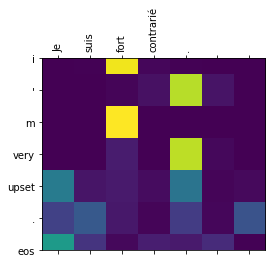

In [69]:
def show_atten_weights(atten_w, in_text, out_text):
    tokenizer = CountVectorizer(token_pattern=r"\b\w+\b|!|\?|\'|\.").build_tokenizer()
    plt.figure()
    plt.matshow(atten_w)
    in_text_list = tokenizer(in_text)
    out_text_list = tokenizer(out_text+' <eos>')
    plt.gca().set_xticks(range(atten_w.shape[1]))
    plt.gca().set_yticks(range(atten_w.shape[0]))
    plt.gca().set_xticklabels(in_text_list, rotation=90)
    plt.gca().set_yticklabels(out_text_list)

ind = np.random.choice(text1.shape[0])
input_text = text1.iloc[ind, 1]
target_text = text1.iloc[ind, 0]
pred_text, atten_w = predict_with_atten(encoder, decoder, input_text)
pred_text = process_text(pred_text)
print('>', input_text)
print('=', target_text)
print('<', pred_text)

print(atten_w.shape)
show_atten_weights(atten_w, input_text, pred_text)

In [45]:
atten_w[0]

array([3.9128802e-04, 1.5847726e-02, 6.6546094e-01, 1.7151047e-01,
       5.9876207e-02, 6.8145514e-02, 1.8767871e-02], dtype=float32)

## show self-attention score

> J'en ai assez entendu.
= I've had enough.
< i had enough.
(7, 7)


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

<Figure size 432x288 with 0 Axes>

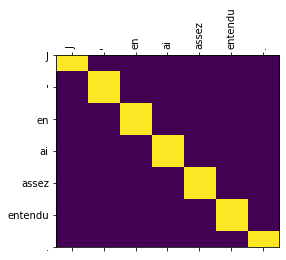

In [144]:
def show_self_atten_weights(input_text, sat_w):
    tokenizer = CountVectorizer(token_pattern=r"\b\w+\b|!|\?|\'|\.").build_tokenizer()
    plt.figure()
    plt.matshow(sat_w)
    text_list = tokenizer(input_text)
    plt.gca().set_xticks(range(len(text_list)))
    plt.gca().set_yticks(range(len(text_list)))
    plt.gca().set_xticklabels(text_list, rotation=90)
    plt.gca().set_yticklabels(text_list)

ind = np.random.choice(text1.shape[0])
input_text = text1.iloc[ind, 1]
target_text = text1.iloc[ind, 0]
pred_text, sat_w = predict_with_self_atten(sat_encoder, decoder, input_text)
pred_text = process_text(pred_text)
print('>', input_text)
print('=', target_text)
print('<', pred_text)

print(sat_w.shape)
show_self_atten_weights(input_text, sat_w)
sat_w

## testing

In [134]:
ind = np.random.choice(text1.shape[0])
input_text = text1.iloc[ind, 1]
target_text = text1.iloc[ind, 0]
pred_text = process_text(predict(sat_encoder, sat_decoder, input_text))
print('>', input_text)
print('=', target_text)
print('<', pred_text)

> Est-ce que j'avais tort ?
= Was I wrong?
< <null> <null> <null> <null> <null> <null> <null> <null> <null>


In [58]:
word_index_eng['gloat']

439

In [85]:
ind = np.random.choice(text2.shape[0])
input_text = text2.iloc[ind, 1]
target_text = text2.iloc[ind, 0]
pred_text = process_text(predict(encoder, decoder, input_text))
print('>', input_text)
print('=', target_text)
print('<', pred_text)

> M'en parle pas.
= Don't tell me.
< don't attack me.


In [49]:
BLEU(process_text("tom is hurt Bad ."), "Tom is hurt bad.")

1.0